In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import copy

# if you don't have gpu, 
# you can set device='cpu'
device = f'cuda:0'

* In this exercise, you will implement isometric representation learning algorithms for the hemisphere surface.   

1. For the hemisphere manifold $\mathcal{M}:=\{(x,y,z)\in\mathbb{R}^{3} | x^2+y^2+z^2=1, z>0\}$, we will consider a local coordinate system $f:\mathbb{R}^2 \to \mathcal{M}$ such that $f(x,y) = (x,y,\sqrt{1-x^2-y^2})$.

In [2]:
def local_coordinates_forward(z):
    '''
    z: torch.tensor whose size = (n, 2)
    '''
    return torch.cat([z, torch.sqrt(1-torch.norm(z, dim=1, keepdim=True)**2)], dim=1)
    
def local_coordinates_inverse(x):
    '''
    x: torch.tensor whose size = (n, 3)
    '''
    return x[:, :2]


* Let's visualize this coordinate system. 

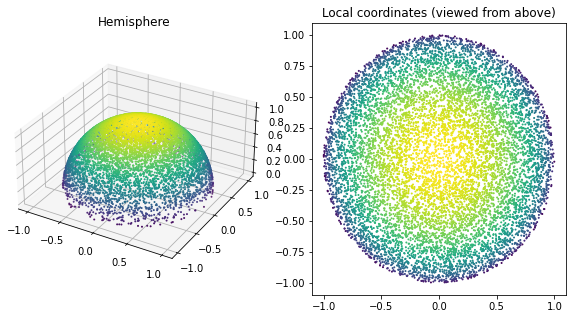

In [3]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 2, 1, projection='3d')
r = torch.sqrt(0.9999*torch.rand(10000, 1))
theta = 2*np.pi*torch.rand(10000, 1)

z = torch.cat(
    [r*torch.cos(theta), r*torch.sin(theta)], dim=1)

x = local_coordinates_forward(z)

def color_map(x):
    # return torch.arctan(x[:, 2]/torch.norm(x[:, :2], dim=1))
    return x[:, 2]

ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=color_map(x), s=1)
xranges = np.ptp(x, axis=0)
ax.set_box_aspect(
    (xranges[0].item(), xranges[1].item(), xranges[2].item())
)
ax.set_title('Hemisphere')

ax = fig.add_subplot(1, 2, 2)
z = local_coordinates_inverse(x)
ax.scatter(z[:, 0], z[:, 1], c=color_map(x), s=1)
ax.set_title('Local coordinates (viewed from above)')
plt.show()

(a) Write the code for computing the Riemannian metric expressed in the above coordinate system.

In [4]:
def metric(z):
    '''
    z:      torch.tensor whose size = (n, 2)
    out:    torch.tensor whose size = (n, 2, 2)
    '''
    
    return 0

* Run the below code block to visualze the Riemannian metrics as equidistant ellipses.

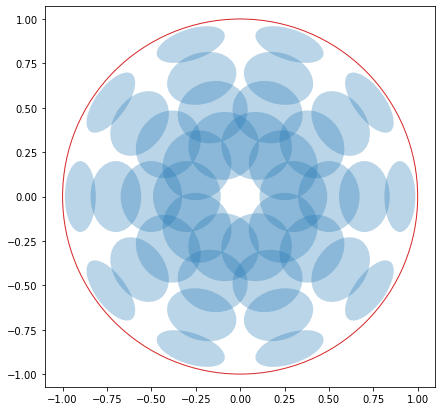

In [5]:
from utils import PD_metric_to_ellipse

points = []
for i in range(10):
    for j in range(4):
        theta = np.pi * 2 / 10 * i
        radius = 0.3 + 0.2 * j
        points.append([radius * np.cos(theta), radius * np.sin(theta)])
points = torch.Tensor(points)

G = metric(points)

# draw figures
f = plt.figure(figsize=(7,7))
ax = plt.gca()
for i, g in enumerate(G):
    e = PD_metric_to_ellipse(np.linalg.inv(g), points[i,:], 0.2, alpha = 0.3)
    ax.add_artist(e)
circle = plt.Circle((0, 0), 1, color='tab:red', fill=False)
ax.add_patch(circle)
ax.set_xlim((-1, 1))
ax.set_ylim((-1, 1))
plt.axis('equal')
plt.show()

Q1) Interpret the result.

2. Now, you will find a near isometric mapping $f$ from the local cooridnate space $U:=\{z\in\mathbb{R}^2|z_1^2+z_2^2 < 1\}$ assigned with the above metric $G(z)$ to the Euclidean space $\mathbb{R}^2$ assigned with the identity metric. We will approximate the mapping $f$ with a fully-connected neural network.

* First of all, we will try to minimize the follwing loss function: $\int_U \sum_{i=1}^{2}(\lambda_i(J^T J G^{-1}) - 1)^2 \sqrt{\det(G)} \ dz$ where $\lambda_i(\cdot)$ denote the eigenvalues and $J$ is the Jacobian of $f$.
* To implement the integration, we will use the Monte-Carlo approximation with the uniform distribution on $U$.
* We will use one of the standard stochastic gradient decent methods.

* Define a fully-connected NN model as below (torch.nn.module class)

In [6]:
from models.modules import FC_vec
model = FC_vec(
    in_chan=2,
    out_chan=2,
    l_hidden=[1024, 1024],
    activation=['relu', 'relu'],
    out_activation='linear',
).to(device);

In [7]:
model

FC_vec(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1024, out_features=2, bias=True)
  )
)

In [8]:
z = torch.randn(10, 2).to(device)
out = model(z)
print(out.size())

torch.Size([10, 2])


* Below function can be used to compute the Jacobian of the above NN model (this was used in HW1_solution.ipynb). 

In [9]:
def jacobian_of_f(f, z, create_graph=True):
    batch_size, z_dim = z.size()
    v = torch.eye(z_dim).unsqueeze(0).repeat(batch_size, 1, 1).view(-1, z_dim).to(z)
    z = z.repeat(1, z_dim).view(-1, z_dim)
    out = (
        torch.autograd.functional.jvp(
            f, z, v=v, create_graph=create_graph
        )[1].view(batch_size, z_dim, -1).permute(0, 2, 1)
    )
    return out 

In [10]:
z = torch.randn(100, 2).to(device)
J = jacobian_of_f(model, z)
print(J.size())

torch.Size([100, 2, 2])


(b) Write the code for the follwing loss function: $\mathbb{E}_{z \sim p(z)} [\sum_{i=1}^{2}(\lambda_i(J^T J G^{-1}) - 1)^2 \sqrt{\det(G)}]$ where $p(z)$ is the uniform distribution on $U$. 

In [11]:
def isometry_loss(f, z_samples):
    '''
    f:          torch.nn.module class 
    z_samples:  torch.tensor whose size = (n, 2) 
    out:        torch.tensor whose size = (1, )
    '''
    
    return 0

In [12]:
# samples from the uniform dist. p(z)
def randn_disk(num_samples, device):
    r = torch.sqrt(0.9999*torch.rand(num_samples, 1))
    theta = 2*np.pi*torch.rand(num_samples, 1)
    z_samples = torch.cat(
        [r*torch.cos(theta), r*torch.sin(theta)], dim=1).to(device)
    return z_samples

# monte-carlo estimation of the loss 
z_samples = randn_disk(1000, device)
isometry_loss(model, z_samples)

tensor(3.6619, device='cuda:0', grad_fn=<MeanBackward0>)

* Now you will minimize the above loss function by using torch autograd libs:  

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

l_losses = []
for epoch in range(300):
    z_samples = randn_disk(1000, device)
    optimizer.zero_grad()
    loss = isometry_loss(model, z_samples)
    l_losses.append(loss.item())
    loss.backward()
    optimizer.step()
    if epoch%100 == 0:
        print(loss.item())
isometry = copy.copy(model)

3.896674394607544
0.6622450947761536
0.6167576909065247


* Plot the loss curve:

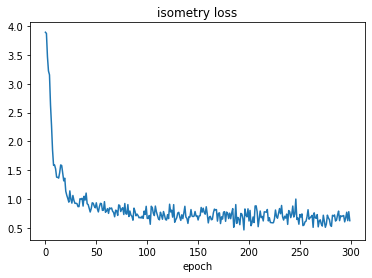

In [14]:
plt.title('isometry loss')
plt.xlabel('epoch')
plt.plot(l_losses)
plt.show()

* Compare the local coordinates and the isometric representation:

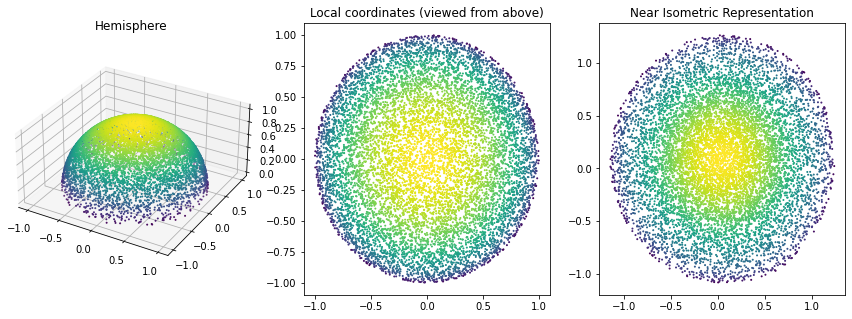

In [15]:
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(1, 3, 1, projection='3d')
r = torch.sqrt(0.9999*torch.rand(10000, 1))
theta = 2*np.pi*torch.rand(10000, 1)

z = torch.cat(
    [r*torch.cos(theta), r*torch.sin(theta)], dim=1)

x = local_coordinates_forward(z)
ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=color_map(x), s=1)
xranges = np.ptp(x, axis=0)
ax.set_box_aspect(
    (xranges[0].item(), xranges[1].item(), xranges[2].item())
)
ax.set_title('Hemisphere')

ax = fig.add_subplot(1, 3, 2)
z = local_coordinates_inverse(x)
ax.scatter(z[:, 0], z[:, 1], c=color_map(x), s=1)
ax.set_title('Local coordinates (viewed from above)')

ax = fig.add_subplot(1, 3, 3)
z_iso = isometry(z.to(device)).detach().cpu()
ax.scatter(z_iso[:, 0], z_iso[:, 1], c=color_map(x), s=1)
ax.set_title('Near Isometric Representation')

plt.show()

Q2) Interpret this result.

* Secondly, we will try to learn the harmonic map with the boundary condition that is $f(z)=z$ for $z\in\partial U:=\{(x,y)\in\mathbb{R}^2|x^2+y^2=1\}$.
* The harmonic loss function can be written as $\int_U \mathrm{Tr}(J^T J G^{-1})\sqrt{\det(G)} \ dz$ where $J$ is the Jacobian of $f$.
* To implement the integration, we will use the Monte-Carlo approximation with the uniform distribution on $U$ as the above.
* Again, we will use one of the standard stochastic gradient decent methods.

(c) Write the code for the follwing loss function: $\mathbb{E}_{z \sim p(z)} [\mathrm{Tr}(J^T J G^{-1})\sqrt{\det(G)}]$ where $p(z)$ is the uniform distribution on $U$. 

In [16]:
def harmonic_loss(f, z_samples):
    '''
    f:          torch.nn.module class 
    z_samples:  torch.tensor whose size = (n, 2) 
    out:        torch.tensor whose size = (1, )
    '''
    
    return 0

(d) To make a neural network model satisfy the boundary condition, we need an additional loss term. Write the code for the boundary loss function.

In [17]:
def boundary_loss(f, z_boundary_samples):
    '''
    f:                   torch.nn.module class 
    z_boundary_samples:  torch.tensor whose size = (n, 2) 
    out:                 torch.tensor whose size = (1, )
    '''
    
    return 0

In [18]:
# samples from the uniform dist. p(z)
def randn_disk(num_samples, device):
    r = torch.sqrt(0.9999*torch.rand(num_samples, 1))
    theta = 2*np.pi*torch.rand(num_samples, 1)
    z_samples = torch.cat(
        [r*torch.cos(theta), r*torch.sin(theta)], dim=1).to(device)
    return z_samples

# samples from the uniform dist. on the boundary \partial U
def randn_boundary(num_samples, device):
    temp = torch.randn(num_samples, 2).to(device)
    z_boundary_samples = temp/torch.norm(temp, dim=1, keepdim=True)
    return z_boundary_samples

# monte-carlo estimation of the loss 
z_boundary_samples = randn_boundary(1000, device)
boundary_loss(model, z_boundary_samples)

tensor(2.3829, device='cuda:0', grad_fn=<MeanBackward0>)

In [19]:
from models.modules import FC_vec
model2 = FC_vec(
    in_chan=2,
    out_chan=2,
    l_hidden=[1024, 1024],
    activation=['relu', 'relu'],
    out_activation='linear',
).to(device);

*Now you will minimize the sum of the harmonic loss and boundary loss by using torch autograd libs:  

In [20]:
optimizer = torch.optim.Adam(model2.parameters(), lr=0.0001)

l_losses = []
for epoch in range(300):
    z_samples = randn_disk(1000, device)
    z_boundary_samples = randn_boundary(100, device)
    optimizer.zero_grad()
    h_loss = harmonic_loss(model2, z_samples)
    b_loss = boundary_loss(model2, z_boundary_samples)
    loss = h_loss + 100*b_loss
    l_losses.append(loss.item())
    loss.backward()
    optimizer.step()
    if epoch%100 == 0:
        print(loss.item())
harmonic_map = copy.copy(model2)

99.95199584960938
2.5565364360809326
2.4017953872680664


* Plot the loss curve

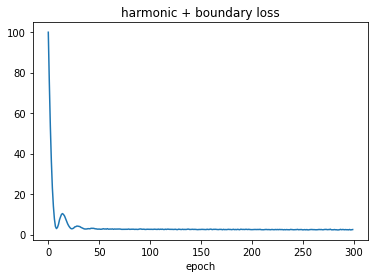

In [21]:
plt.title('harmonic + boundary loss')
plt.xlabel('epoch')
plt.plot(l_losses)
plt.show()

* Compare the local coordinates, the isometric representation, and the harmonic representation:

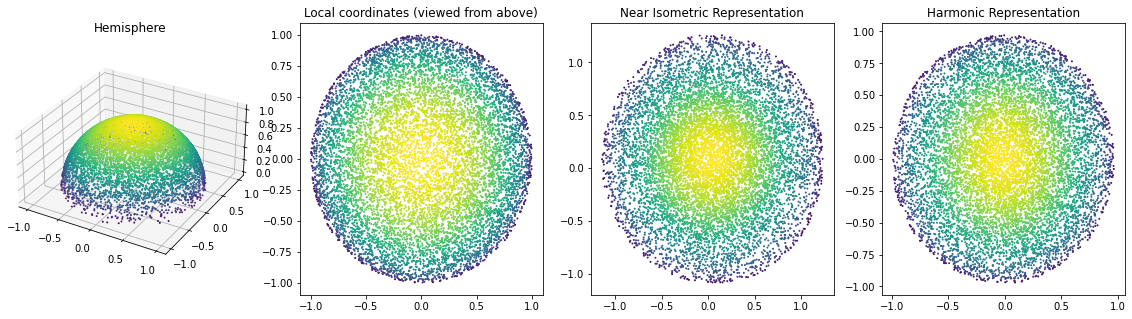

In [22]:
fig = plt.figure(figsize=(20, 5))

ax = fig.add_subplot(1, 4, 1, projection='3d')
r = torch.sqrt(0.9999*torch.rand(10000, 1))
theta = 2*np.pi*torch.rand(10000, 1)

z = torch.cat(
    [r*torch.cos(theta), r*torch.sin(theta)], dim=1)

x = local_coordinates_forward(z)
ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=color_map(x), s=1)
xranges = np.ptp(x, axis=0)
ax.set_box_aspect(
    (xranges[0].item(), xranges[1].item(), xranges[2].item())
)
ax.set_title('Hemisphere')

ax = fig.add_subplot(1, 4, 2)
z = local_coordinates_inverse(x)
ax.scatter(z[:, 0], z[:, 1], c=color_map(x), s=1)
ax.set_title('Local coordinates (viewed from above)')

ax = fig.add_subplot(1, 4, 3)
z_iso = isometry(z.to(device)).detach().cpu()
ax.scatter(z_iso[:, 0], z_iso[:, 1], c=color_map(x), s=1)
ax.set_title('Near Isometric Representation')

ax = fig.add_subplot(1, 4, 4)
z_harmonic = harmonic_map(z.to(device)).detach().cpu()
ax.scatter(z_harmonic[:, 0], z_harmonic[:, 1], c=color_map(x), s=1)
ax.set_title('Harmonic Representation')
plt.show()

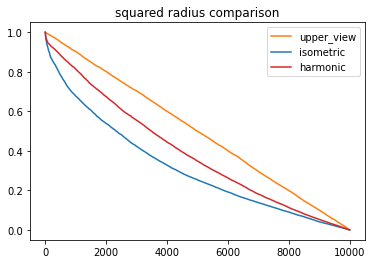

In [40]:
plt.title('squared radius comparison')
r_upper_view = torch.norm(z, dim=1).sort(descending=True).values
r_iso = torch.norm(z_iso, dim=1).sort(descending=True).values
r_iso = r_iso/r_iso.max()
r_harmonic = torch.norm(z_harmonic, dim=1).sort(descending=True).values
r_harmonic = r_harmonic/r_harmonic.max()
plt.plot(r_upper_view**2, c='tab:orange', label='upper_view')
plt.plot(r_iso**2, c='tab:blue', label='isometric')
plt.plot(r_harmonic**2, c='tab:red', label='harmonic')
plt.legend()
plt.show()

Q3) How are they different? Compare and analyze the results.

* So far we have studied the toy case. You can find many more advanced usages of the isometric loss and harmonic loss functions.  
* One particular example usage in deep representation learning can be found in the paper "Regularized Autoencoders for Isometric Representation Learning (ICLR 2022, Y.H. Lee et al.)"
* Those who are interested in knowing how theses types of geometry-preserving loss functions can be used in practice, e.g., for image data representation learning, we refer to the following github page: https://github.com/Gabe-YHLee/IRVAE-public. 